In [ ]:
import numpy as np
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.gofplots import qqplot
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# Load dataset
df = pd.read_csv('/content/TB Dataset 2024.csv', index_col=0, parse_dates=True)
df['Cases'] = pd.to_numeric(df['Cases'], errors='coerce')
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(subset=['Cases'], inplace=True)
df['Cases'] = df['Cases'].astype(float)
df.fillna(method='ffill', inplace=True)

print('Shape of data:', df.shape)
print('Original Dataset:', df.head())


Shape of data: (90, 1)
Original Dataset:            Cases
Months          
Jan-17  144781.0
Feb-17  147133.0
Mar-17  176283.0
Apr-17  160671.0
May-17  161146.0


<ipython-input-2-df0c218bcccb>:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv('/content/TB Dataset 2024.csv', index_col=0, parse_dates=True)
<ipython-input-2-df0c218bcccb>:7: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


In [ ]:
# Set black, gray, and white theme
plt.style.use('grayscale')  # Converts plots to grayscale
sns.set_style("darkgrid")

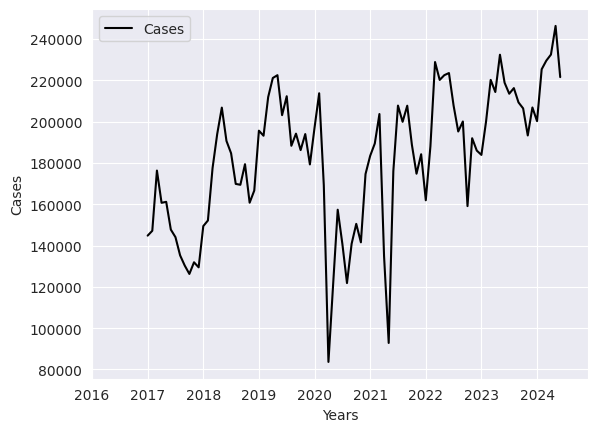

In [ ]:
X = df['Cases'].values
import matplotlib.pyplot as plt
import pandas as pd

# Ensure the index is in datetime format
df.index = pd.to_datetime(df.index, format='%b-%y')
#df.index = pd.to_datetime(df.index)


# Plot the data
ax = df.plot(y='Cases', legend=True)

# Set x-axis limits from 2017 to 2024
ax.set_xlim(pd.Timestamp('2016-01-01'), pd.Timestamp('2024-12-31'))

# Label axes
plt.xlabel("Years")
plt.ylabel("Cases")

# Show the plot
plt.show()


In [ ]:
#df= df.fillna(method='ffill')#Remove NaN and fill it with the number before

In [ ]:
#train, test = train_test_split(df, test_size=0.2, shuffle=False)
#Splitting into train & test sets
train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]

In [ ]:
p=1
d=0
q=1
P=1
D=0
Q=0
m=12
#sarima_model = SARIMAX(train, order=(p, d, q), seasonal_order=(P, D, Q, m)).fit(disp=False)
sarima_model = SARIMAX(train['Cases'], order=(p, d, q), seasonal_order=(P, D, Q, m)).fit()

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


In [ ]:
# Fit SARIMA model
#sarima_model = SARIMAX(train['Cases'], order=(p, d, q), seasonal_order=(P, D, Q, m)).fit()
# SARIMA Predictions
sarima_train_pred = sarima_model.fittedvalues
sarima_pred = sarima_model.forecast(steps=len(test))

In [ ]:
#sarima_pred = sarima_model.forecast(steps=len(test))
#residuals = test['Cases'] - sarima_pred
# Compute Residuals (Observed - Predicted)
residuals = test['Cases'].values - sarima_pred.values
train_residuals = train['Cases'].values - sarima_train_pred.values

In [ ]:
#residuals = residuals.fillna(0)
#residuals = residuals.replace([np.inf, -np.inf], 0)

In [ ]:
#sarima_train_pred = sarima_model.fittedvalues
# Handle NaN or Inf in residuals
residuals = np.nan_to_num(residuals)
train_residuals = np.nan_to_num(train_residuals)
#train_residuals = train['Cases'].values - sarima_train_pred


In [ ]:
#train_residuals = train_residuals.fillna(0)
#train_residuals = train_residuals.replace([np.inf, -np.inf], 0)


In [ ]:
# Normalize residuals for NNAR
scaler = MinMaxScaler()
residuals_scaled = scaler.fit_transform(residuals.reshape(-1, 1))
train_residuals_scaled = scaler.fit_transform(train_residuals.reshape(-1, 1))
#residuals_scaled = scaler.fit_transform(residuals.values.reshape(-1, 1))
#train_residuals_scaled = scaler.fit_transform(train_residuals.values.reshape(-1, 1))


In [ ]:
X = []
y = []
lag = 12
for i in range(lag, len(residuals_scaled)):
    X.append(residuals_scaled[i - lag:i, 0])
    y.append(residuals_scaled[i, 0])

X, y = np.array(X), np.array(y)

In [ ]:
X_train_nnar, y_train_nnar = [], []
for i in range(lag, len(train_residuals_scaled)):
    X_train_nnar.append(train_residuals_scaled[i - lag:i, 0])
    y_train_nnar.append(train_residuals_scaled[i, 0])
X_train_nnar, y_train_nnar = np.array(X_train_nnar), np.array(y_train_nnar)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
nnar_model = MLPRegressor(hidden_layer_sizes=(50, 50), max_iter=1000, random_state=42)#Has two hidden layers each containing 50 neurons
model_fit=nnar_model.fit(X_train, y_train)


In [ ]:
nnar_pred_scaled = model_fit.predict(X_test)
nnar_pred = scaler.inverse_transform(nnar_pred_scaled.reshape(-1, 1))


In [ ]:
nnar_train_pred_scaled = nnar_model.predict(X_train_nnar)
nnar_train_pred = scaler.inverse_transform(nnar_train_pred_scaled.reshape(-1, 1))

In [ ]:
#hybrid_pred = sarima_pred[:len(test)] + nnar_pred.flatten()[:len(test)]
#hybrid_train_pred = sarima_train_pred[lag:] + nnar_train_pred.flatten()

# Hybrid Model: SARIMA Prediction + NNAR Residuals Correction
hybrid_pred = sarima_pred[:len(nnar_pred)] + nnar_pred.flatten()
# Hybrid Model: SARIMA Prediction + NNAR Residuals Correction
#hybrid_pred = sarima_pred + nnar_pred.flatten()[:len(sarima_pred)]
hybrid_train_pred = sarima_train_pred[lag:] + nnar_train_pred.flatten()


In [ ]:
# Residual Analysis
hybrid_pred_aligned = hybrid_pred[:len(test['Cases'])]  # Adjust hybrid_pred length
if len(hybrid_pred_aligned) != len(test['Cases']):
    # Pad or truncate hybrid_pred_aligned to match the length of test['Cases']
    # Here, we pad with the last value to ensure compatibility
    # (you can choose a different padding strategy if needed)
    hybrid_pred_aligned = np.pad(hybrid_pred_aligned, (0, len(test['Cases']) - len(hybrid_pred_aligned)), 'edge')

hybrid_residuals = test['Cases'].values - hybrid_pred_aligned
# Ensure residuals are a NumPy array
hybrid_residuals = np.array(hybrid_residuals).flatten()

# Check the length of residuals
print(f"Length of residuals: {len(hybrid_residuals)}")

Length of residuals: 18


In [ ]:
#Function to create plots with an expanded first graph
import statsmodels.tsa.stattools as sm # Import the statsmodels library with alias sm
import matplotlib.pyplot as plt
import seaborn as sns # Import seaborn for distribution plots
import numpy as np
from statsmodels.tsa.stattools import acf

In [ ]:
#hybrid_residuals = np.random.normal(0, 1, 60)
time=range(len(hybrid_residuals))

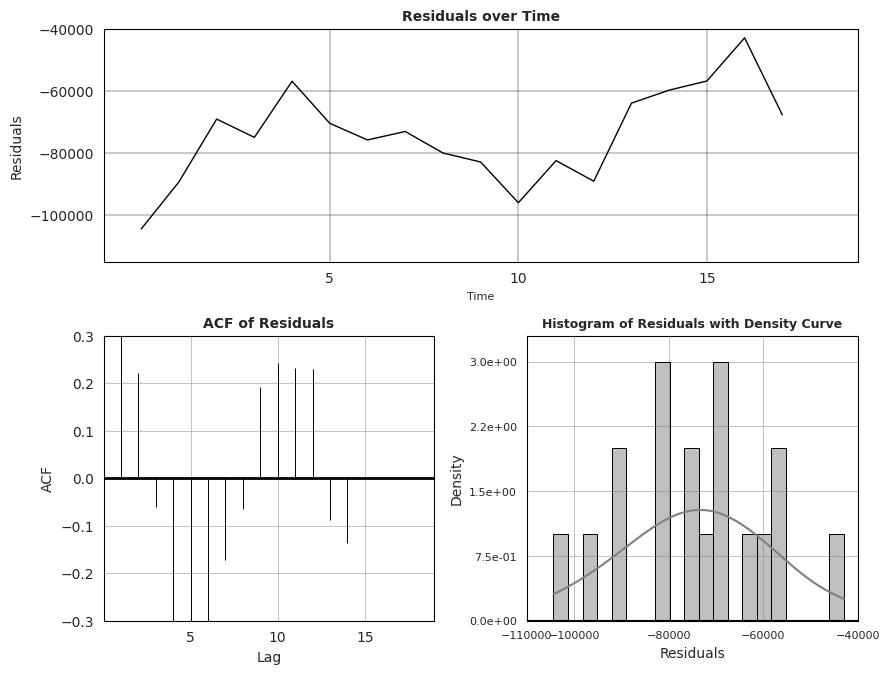

In [ ]:
#Function to create plots with an expanded first graph
def plot_residual_analysis(figsize=(9,15)):
    fig = plt.figure(figsize=figsize)
    fig.patch.set_facecolor('white')

 # Create grid layout: (3 , 2 columns)
    gs = fig.add_gridspec(3, 2, height_ratios=[9, 11, 11])  # First row larger

    # Residuals over time (spanning both columns in first row)
    ax1 = fig.add_subplot(gs[0, :])  # Spans across both columns
    #ax1.plot(test.index[p + m:], residuals, marker='o', linestyle='dashed', color='gray')
    #time_array = np.arange(len(residuals))
    ax1.plot(time, hybrid_residuals, color='black', linewidth=1.0)
    ax1.set_facecolor('white')
    ax1.set_title("Residuals over Time", fontsize=10,fontweight='bold')
    ax1.set_xlabel("Time", fontsize=8)
    ax1.set_ylabel("Residuals", fontsize=10)

    ax1.set_xlim(-1, 19)
    ax1.set_ylim(-115000,-40500 )
    ax1.set_xticks([5,10,15])
    ax1.set_yticks([-100000,-80000,-60000,-40000])


    # Scale x-axis from 0 to 15 with a step of 5
    #x_tick_range = np.arange(0, 16, 5)  # 0, 5, 10, 15
    #y_tick_range=np.arange(0, 65000,20000)
    #ax1.set_xticks(x_tick_range)
    #ax1.set_yticks(y_tick_range)
    #ax1.set_xlim(-1, 16)  # Ensure the x-axis is correctly limited
    #ax1.set_ylim(-20000, 65000)  # Ensure the y-axis is correctly limited
    #ax1.set_xticklabels(x_tick_range.astype(int))  # Convert to integers
    #ax1.set_yticklabels(y_tick_range.astype(int))
    #ax1.set_yticks(np.arange(0, max(residuals) + 2000, 20000))  # Y-axis in steps of 20000
    ax1.grid(True, linestyle='-', linewidth=0.3, color='black')

    #x_tick_range = np.linspace(0, len(residuals) -1, 5)  # 5 ticks across the range
    #ax1.set_xticks(x_tick_range) # Set x-axis ticks using numerical values
    #ax1.set_xticklabels(x_tick_range.astype(int)) # Format x-axis tick labels as dates
    #ax1.set_yticks(np.arange(0, max(residuals) + 2000, 20000))  # Y-axis in steps of 20000
    #ax1.set_xlim(min(time), max(time))
    #ax1.set_ylim(min(residuals) - 5000, max(residuals) + 5000)
    #ax1.grid(True, linestyle='-', linewidth=0.3, color='darkgray')

    # ACF of Residuals (with larger size and only lines)
    ax2 = fig.add_subplot(gs[1, 0])  # ACF spans across both columns
    lags = np.arange(0, 15)  # Define lags
    acf_values = sm.acf(hybrid_residuals.squeeze(), nlags=len(hybrid_residuals) - 1)  # Compute ACF

     # Compute critical values at 95% confidence level
    n = len(hybrid_residuals)
    conf_interval = 1.96 / np.sqrt(n)

    ax2.vlines(lags, 0, acf_values[:15], color='black', linewidth=0.7)  # ACF vertical lines
    ax2.axhline(0, color='black', linestyle='-', linewidth=2.0)  # Reference line at 0

    # Add critical value lines (blue, dotted)
    #ax2.axhline(conf_interval, color='blue', linestyle='--', linewidth=0.7)
    #ax2.axhline(-conf_interval, color='blue', linestyle='--', linewidth=0.7)
    ax2.set_xticks([5, 10, 15])

    ax2.set_facecolor('white')
    ax2.set_title("ACF of Residuals",  fontsize=10,fontweight='bold')
    ax2.set_xlabel("Lag", fontsize=10)
    ax2.set_ylabel("ACF", fontsize=10)
    #ax2.set_ylim(-0.50, 0.50)  # Set y-axis limits from -0.50 to 0.50
    #ax2.set_xlim(0, 16)
    ax2.set_ylim(-0.3, 0.3)  # Set y-axis limits from -0.50 to 0.50
    ax2.set_xlim(0, 19)
    ax2.grid(True, linestyle='-', linewidth=0.5,color='darkgray')

    # Histogram with density
    ax3 = fig.add_subplot(gs[1, 1])
    ax3.set_facecolor('white')
    # Plot histogram (gray bars with black edges)
    sns.histplot(hybrid_residuals, kde=True, bins=20, color='gray', edgecolor='black', linewidth=0.7, ax=ax3)

    # Plot KDE (red line)
    sns.kdeplot(hybrid_residuals, color='black', linewidth=1.5, ax=ax3, fill=False)

    # Set title and labels
    ax3.set_title("Histogram of Residuals with Density Curve",  fontsize=9,fontweight='bold')
    ax3.set_xlabel("Residuals", fontsize=10)
    ax3.set_ylabel("Density", fontsize=10)
    ax3.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.1e'))
    # Set x and y limits
    ax3.set_xlim(-110000, -40000)  # X-axis from 0 to 60000
    ax3.set_ylim(0.0e+00, 3.3e+00)
    ax3.set_xticks([-110000,-100000,-80000,-60000,-40000])
    ax3.set_yticks([0.0e+00,0.75e+00,1.5e+00,2.25e+00,3.0e+00])

    # Customize grid (light gray, matching the image)
    ax3.grid(True, linestyle='-', linewidth=0.5, color='darkgray')

    # Adjust tick label size
    ax3.tick_params(axis='both', labelsize=8)

    # Histogram with density
    #ax3 = fig.add_subplot(gs[1, 1])
    #sns.histplot(residuals, kde=True, ax=ax3, color='gray', bins=20,edgecolor='black',linewidth=0.7)

    # Explicit KDE (red curve)
    #sns.kdeplot(residuals, ax=ax3, color='red', linewidth=1.5, fill=False)

    #ax3.set_facecolor('white')
    #ax3.set_title("Histogram of Residuals with Density Curve", fontsize=8)
    #ax3.set_xlabel("Residuals", fontsize=8)
    #ax3.set_ylabel("Density", fontsize=8)
    #ax3.grid(True, linestyle='-', linewidth=0.3,color='darkgray')
    for ax in [ax1, ax2, ax3]:
        for spine in ax.spines.values():
            spine.set_edgecolor('black')  # Set border color to black
            spine.set_linewidth(0.8)  # Adjust thickness of the border

    # Adjust layout
    plt.tight_layout()
    plt.show()
plot_residual_analysis(figsize=(9, 10))

In [ ]:
# Assuming 'df' is your original DataFrame and 'train_size' is the split point
hybrid_pred = sarima_model.predict(start=train_size, end=len(df)-1)

In [ ]:
mse = mean_squared_error(test['Cases'], hybrid_pred)
print(f"Mean Squared Error of Hybrid Model: {mse}")


Mean Squared Error of Hybrid Model: 2732402650.317131


In [ ]:
rmse=np.sqrt(mse)
print(f"Root Mean Squared Error of Hybrid Model: {rmse}")
mae=np.mean(np.abs(test['Cases'].values - hybrid_pred))
print(f"Mean Absolute Error of Hybrid Model: {mae}")
mape = np.mean(np.abs((test['Cases'].values - hybrid_pred) / test['Cases'].values)) * 100
print(f"Mean Absolute Percentage Error of Hybrid Model: {mape}")

Root Mean Squared Error of Hybrid Model: 52272.38898612853
Mean Absolute Error of Hybrid Model: 47273.80612639442
Mean Absolute Percentage Error of Hybrid Model: 21.480354306961694


In [ ]:
mse_train = mean_squared_error(train.values[lag:], hybrid_train_pred)
print(f"Mean Squared Error of Hybrid Model (Training): {mse_train}")

Mean Squared Error of Hybrid Model (Training): 11131588131.97129


In [ ]:
rmse=np.sqrt(mse_train)
print(f"Root Mean Squared Error of Hybrid Model (Training): {rmse}")
mae=np.mean(np.abs(train['Cases'].values[lag:] - hybrid_train_pred))
print(f"Mean Absolute Error of Hybrid Model (Training): {mae}")
mape= np.mean(np.abs((train['Cases'].values[lag:] - hybrid_train_pred) / train['Cases'].values[lag:])) * 100
print(f"Mean Absolute Percentage Error of Hybrid Model (Training): {mape}")

Root Mean Squared Error of Hybrid Model (Training): 105506.34166708316
Mean Absolute Error of Hybrid Model (Training): 101452.87873596183
Mean Absolute Percentage Error of Hybrid Model (Training): 59.9028898487585


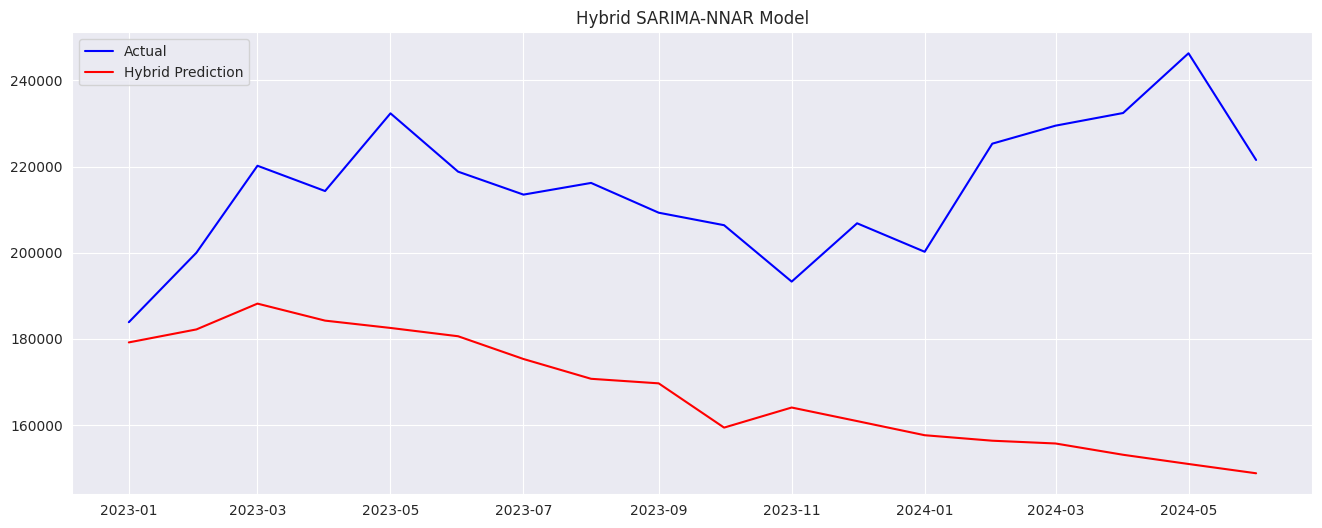

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 6))
plt.plot(test.index, test, label="Actual",color='blue')
plt.plot(test.index, hybrid_pred, label="Hybrid Prediction", linestyle="-",color='red')
plt.legend()
plt.title("Hybrid SARIMA-NNAR Model")
plt.show()


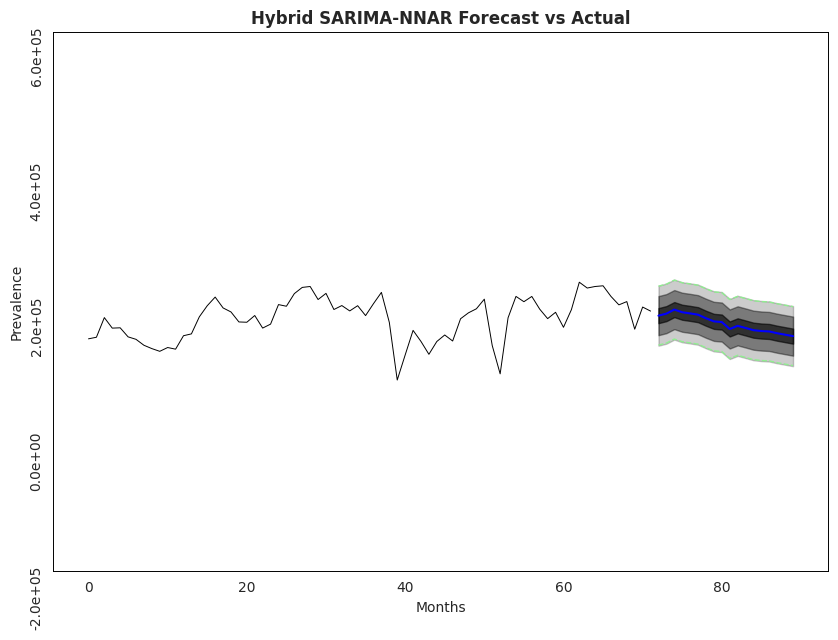

In [ ]:
import matplotlib.ticker as ticker
import numpy as np
import matplotlib.pyplot as plt

dates = df.index
# Compute standard deviation for credible interval
forecast_std = np.std(test['Cases'].values - hybrid_pred.values) # Convert hybrid_pred to NumPy array
lower_bound = hybrid_pred.values.flatten() - 1.96 * forecast_std  # Use .values to get NumPy array and then flatten
upper_bound = hybrid_pred.values.flatten() + 1.96 * forecast_std  # Use .values to get NumPy array and then flatten

# Create index-based x-axis
x_train = np.arange(len(train))  # Training data indices
x_test = np.arange(len(train), len(train) + len(test))  # Test data indices

fig, ax = plt.subplots(figsize=(10, 7))  # Set figure size if needed
fig.patch.set_facecolor('white')  # Set figure background to white
ax.set_facecolor('white')  # Set plot area background to white
ax.grid(False)  # Remove grid

# Plot
# Plot training data
ax.plot(x_train, train['Cases'].values, color='black', linestyle='-', linewidth=0.7, label="Training Data")

# Plot test data and hybrid forecast
ax.plot(x_test, hybrid_pred, color='blue', label="Hybrid Forecast")

# Gradient effect for credible interval
for alpha, scale in zip([0.6, 0.4, 0.2], [0.5, 1.3, 2.0]):
    ax.fill_between(x_test,
                    hybrid_pred.values.flatten() - scale * forecast_std,
                    hybrid_pred.values.flatten() + scale * forecast_std,
                    color='black', alpha=alpha)

# Add green dotted boundary lines for the credible interval
ax.plot(x_test, lower_bound, color='lightgreen', linestyle='--', linewidth=1.0, label="Lower Bound")
ax.plot(x_test, upper_bound, color='lightgreen', linestyle='--', linewidth=1.0, label="Upper Bound")

# Set scientific notation on y-axis
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.1e'))  # Format as scientific notation (1 decimal)
plt.xticks(rotation=360)
plt.yticks(rotation=90)
ax.set_yticks([-2e5, 0, 2e5, 4e5, 6e5])  # Only label these values
ax.tick_params(axis='y', labelsize=10)
# Set y-axis range to match first image
ax.set_ylim(-2e5, 6e5)  # Set y-axis limits
# Add outline (border) on all four sides
for spine in ax.spines.values():
    spine.set_edgecolor('black')  # Set border color to black
    spine.set_linewidth(0.7)  # Adjust thickness of the border
ax.set_title("Hybrid SARIMA-NNAR Forecast vs Actual",fontsize=12,fontweight'bold')
ax.set_xlabel("Months")
ax.set_ylabel("Prevalence")
plt.show()
